# 获取数据
MINST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1, data_home="./")

In [3]:
for key in mnist.keys():
    print(key)

data
target
frame
categories
feature_names
target_names
DESCR
details
url


In [4]:
# 获取data
mnist_data = mnist["data"]
mnist_data.shape

(70000, 784)

In [5]:
# 获取target
mnist_target = mnist["target"]
mnist_target.shape

(70000,)

## 查看数据

数据中的相互转化
1. pandas DataFrame 转换为numpy array 方法为pd.values pd.array 或 pd.to_numpy()
2. pandas DataFrame 转换为python list 方法为 pd.values.tolist()
3. numpy array 转换为python list 方法为 np.tolist()

pandas 中DataFrame相当于numpy二维向量， Series相当于numpy一维向量
1. pandas DataFrame 获取一维向量Series 方法为 pd.loc[] 或 pd.iloc[]
2. numpy array 获取一维向量 方法为 np[]

(-0.5, 27.5, 27.5, -0.5)

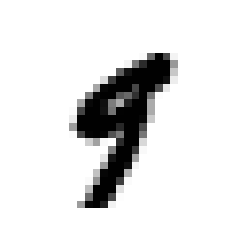

In [6]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

some_digit = mnist_data.loc[36000,:]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap=plt.cm.binary, interpolation='nearest')
plt.axis('off')

In [7]:
mnist_target.loc[36000]

'9'

## 区分训练集和测试集

In [8]:
mnist_data_train, mnist_data_test, mnist_target_train, mnist_target_test = \
mnist_data.loc[:60000,:].values, mnist_data.loc[60000:,:].values, \
mnist_target.loc[:60000].to_numpy(), mnist_target.loc[60000:].to_numpy()
print(type(mnist_target_train))

<class 'numpy.ndarray'>


# 训练数据

## 一个二分类器

数据说明
训练集<br>
mnist_data_train<br>
mnist_target_train_9<br>
测试集<br>
mnist_data_test<br>
mnist_target_test_9<br>

In [9]:
mnist_target_train = np.array([int(x) for x in mnist_target_train],dtype=np.int32)
mnist_target_train_9 = (mnist_target_train == 9)
res_train = np.sum(mnist_target_train_9 == True)
print(res_train)
mnist_target_test = np.array([int(x) for x in mnist_target_test], dtype=np.int32)
mnist_target_test_9 = (mnist_target_test == 9)
res_test = np.sum(mnist_target_test_9 == True)
print(res_test)

5949
1009


In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(mnist_data_train,mnist_target_train_9)

SGDClassifier(random_state=42)

In [11]:
print(sgd_clf.coef_.shape)
sgd_clf.predict(some_digit.values.reshape(1,-1))

(1, 784)


array([False])

## 二分类器模型验证

### 使用k折交叉验证
1. 分层 - StratifiedShuffledSplit
2. k折 - StratifiedKFold

* 注意，k折交叉验证应当发生在训练集上而非测试集上，只有当模型完全满意时才可以使用测试集

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_index, test_index in skfolds.split(mnist_data_train, mnist_target_train_9):
    clone_clf = clone(sgd_clf)
    x_train_fold = mnist_data_train[train_index]
    y_train_fold = mnist_target_train_9[train_index]
    x_test_fold = mnist_data_train[test_index]
    y_test_fold = mnist_target_train_9[test_index]
    clone_clf.fit(x_train_fold, y_train_fold)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    precision = n_correct / len(y_pred)
    print(precision)

0.9532023398830058
0.941
0.9441


### 交叉验证

1. 使用k折交叉验证时同样会改变模型的参数
2. cross_val_score 的目的是将训练集分为k折，其中一折进行预测，剩余折进行训练
3. cross_val_score 在区分数据集的同时还会对模型进行训练，最后输出的模型是每一次训练后所有超参数的平均值

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, mnist_data_train, mnist_target_train_9, cv=3, scoring='accuracy')

array([0.95145243, 0.88365   , 0.94165   ])

### 自定义分类器

In [14]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, mnist_data_train, mnist_target_train_9, cv=3, scoring='accuracy')

array([0.89930503, 0.8999    , 0.90335   ])

### 混淆矩阵查看分类正确率
* 我们经常使用实际发生概率较小的事件作为1事件，对其的预测成为“真预测”
* 一句话理解：准确率计算预测为真的样本中实际为真的概率；召回率计算实际为真的样本中预测为真的概率

<table border="1" style="float:center; text-align: center">
    <tr>
        <th></th>
        <th>预测为真</th>
        <th>预测为假</th>
    </tr>
    <tr>
        <td>实际为真</td>
        <td>True Positive</td>
        <td>False Negative</td>
    </tr>
        <tr>
        <td>实际为假</td>
        <td>False Positive</td>
        <td>True Negative</td>
    </tr>
</table>

1. 准确率
$$ precision = 
   \frac{TruePositive}{TruePositive + FalsePositive}
$$
<br>
2. 召回率
$$ callback = 
   \frac{TruePositive}{TruePositive + FalseNegative}
$$
3. F1
$$ f1 = 
    \frac{2}{\frac{1}{precision} + \frac{1}{recall}}
$$

混乱矩阵计算公式为
1. sklearn.metrics confusion_matrix

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, mnist_data_train, mnist_target_train_9, cv=3)
y_confusion_matrix = confusion_matrix(mnist_target_train_9, y_train_pred)
y_confusion_matrix

array([[51427,  2625],
       [ 1840,  4109]])

准确率和召回率的计算公式
1. 准确率 sklearn.metrics precision_score
2. 召回率 sklearn.metrics recall_score
3. F1值 sklearn.metrics f1_score

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

pre_score = precision_score(mnist_target_train_9, y_train_pred)
print("precision: {:.4f}".format(pre_score))
rec_score = recall_score(mnist_target_train_9, y_train_pred)
print("recall: {:.4f}".format(rec_score))
f1_score = f1_score(mnist_target_train_9,y_train_pred)
print("f1: {:.4f}".format(f1_score))

precision: 0.6102
recall: 0.6907
f1: 0.6480


### 模型参数

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[-1476.5021733]


array([False])

### 确定threshold参数值

#### precision_recall 曲线

cross_val_predict 类中<br>
method 设定为 decision_function<br>
这样可以得到每一个数据点的预测值<br>

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, mnist_data_train, mnist_target_train_9, 
                             cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(mnist_target_train_9, y_scores)
print(precisions)
print(recalls)
print(thresholds)

[0.10190483 0.10188944 0.10189119 ... 1.         1.         1.        ]
[1.00000000e+00 9.99831905e-01 9.99831905e-01 ... 3.36190956e-04
 1.68095478e-04 0.00000000e+00]
[-59325.80369791 -59311.67496218 -59308.64095893 ...  20333.83290298
  20858.37233405  21028.6272405 ]


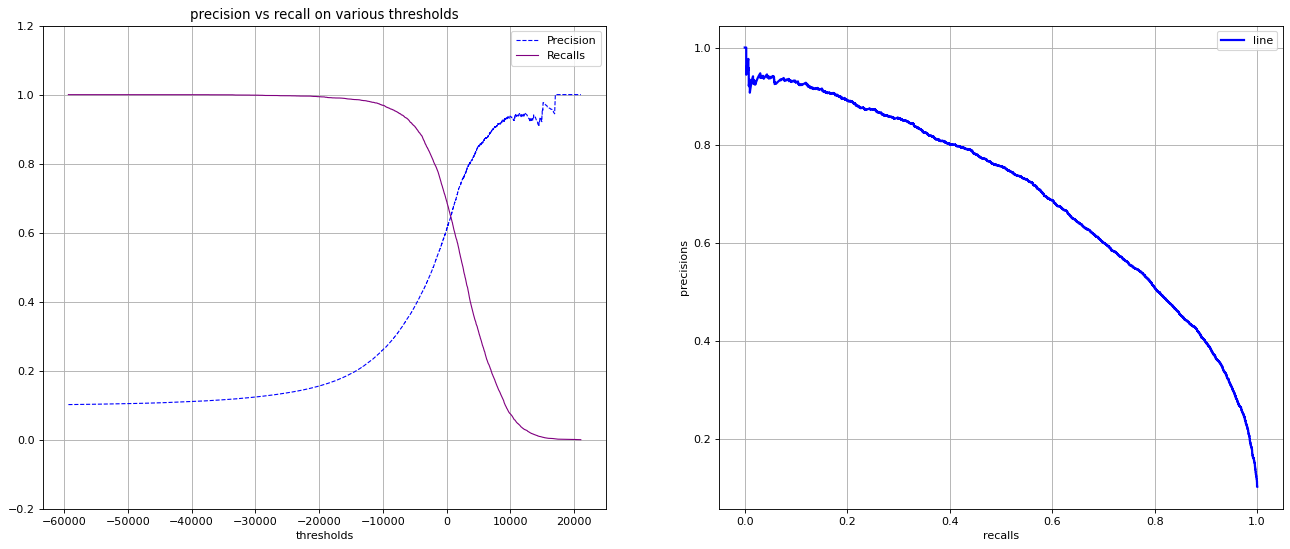

In [19]:
# print(precisions.shape)
# print(recalls.shape)
# print(thresholds.shape)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig,axes = plt.subplots(1,2,figsize=(20,8),dpi=80)
    ax1 = axes[0]
    ax2 = axes[1]
    ax1.plot(thresholds,precisions[:-1],
             lw=1,ls='--',color='blue',
             label='Precision')
    ax1.plot(thresholds,recalls[:-1],
             lw=1,ls='-',color='purple',
             label='Recalls')
    ax1.set_title('precision vs recall on various thresholds')
    ax1.set_xlabel('thresholds')
    ax1.legend()
    ax1.grid()
    ax1.set_ylim([-0.2,1.2])
    
    ax2.plot(recalls, precisions, 
             ls='-', lw=2, color='blue',
             label='line')
    ax2.set_xlabel('recalls')
    ax2.set_ylabel('precisions')
    ax2.legend()
    ax2.grid()
  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

1. 接下来通过控制precision的值找到相应的threshold
2. 通过precision_score(label,predict)以及recall_score(label,predict)计算相应的值
3. 进行模型评估

#### ROC曲线 Receiver Operational Curve

<table border="1" style="float:center; text-align: center">
    <tr>
        <th></th>
        <th>预测为真</th>
        <th>预测为假</th>
    </tr>
    <tr>
        <td>实际为真</td>
        <td>True Positive</td>
        <td>False Negative</td>
    </tr>
        <tr>
        <td>实际为假</td>
        <td>False Positive</td>
        <td>True Negative</td>
    </tr>
</table>

1. TPR True Positive Rate
$$
TPR = \frac{TruePositive}{TruePositive + FalseNegative}
$$
2. FPR False Positive Rate
$$
FPR = \frac{FalsePositive}{TrueNegative + FalsePositive}
$$

* ROC 曲线绘制的是TPR-FPR关系曲线
* 我们可以通过AUC(Area Under ROC Curve)判断二分类器的优劣
* ROC曲线相当于Positive分类输出值排在Negative分类输出值之前的概率

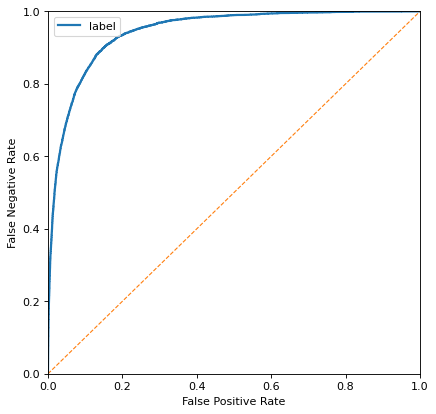

In [20]:
from sklearn.metrics import roc_curve
# y_scores 是所有标注为9的样本的训练后输出值
fpr, tpr, thresholds = roc_curve(mnist_target_train_9, y_scores)

def plot_roc_curve(fpr, tpr, thresholds):
    plt.figure(figsize=(6,6),dpi=80)
    plt.plot(fpr, tpr, lw=2, label='label')
    plt.plot([0,1],[0,1],ls='--',lw=1)
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('False Negative Rate')
    plt.legend()
    
plot_roc_curve(fpr, tpr, thresholds) 

In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score = roc_auc_score(mnist_target_train_9, y_scores)
print(roc_auc_score)

0.9439911072478882


## 随机森林二分类器

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, mnist_data_train, mnist_target_train_9,
                                   cv=3, method="predict_proba")
# 输出有两行，选取第一行概率作为预测输出值
y_forest_scores = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(mnist_target_train_9, y_forest_scores)

(0.0, 1.0)

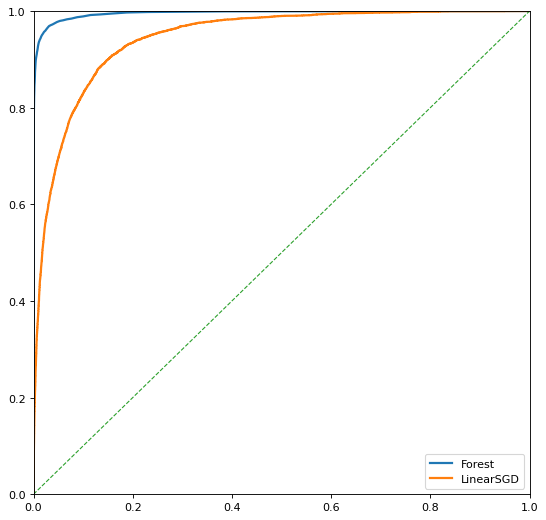

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,8), dpi=80)
plt.plot(fpr_forest, tpr_forest, lw=2, ls='-', label='Forest')
plt.plot(fpr, tpr, lw=2, ls='-', label='LinearSGD')
plt.plot([0,1],[0,1],lw=1,ls='--')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])

In [24]:
roc_auc_score(mnist_target_train_9, y_forest_scores)

0.9954215564780469

## 一个多分类器

1. SGDLinear Classifier实际上是一个 OvA 的多分类器，如果需要区分10个类别，那么相当于训练了10个不同的二分类器
2. 参数命名
    1. 多分类器名称为 sgd_ova_clf
    2. 训练集数据 mnist_data_train | mnist_data
    3. 训练集标签 mnist_target_train | mnist_target
    4. 训练集标准化后数据 mnist_data_scaled

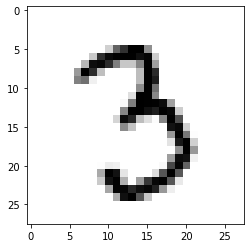

In [25]:
from matplotlib import pyplot as plt

sp_sample = mnist_data.iloc[30000,:]
sp_sample_image = sp_sample.values.reshape([28,28])
plt.imshow(sp_sample_image,cmap=matplotlib.cm.binary, interpolation='nearest')
plt.show()

In [26]:
from sklearn.linear_model import SGDClassifier

sgd_ova_clf = SGDClassifier(random_state=42)
sgd_ova_clf.fit(mnist_data_train, mnist_target_train)

sgd_ova_clf.predict([sp_sample])

array([3], dtype=int32)

### 查看OVA多分类器中所有分类结果

In [27]:
sp_sample_scores = sgd_ova_clf.decision_function([sp_sample])
sp_sample_scores

array([[-25497.5109939 ,  -5247.20916597, -12678.41171319,
          2062.47013043, -26145.01855649, -10072.47136107,
        -18706.62975622, -13442.68260389,  -5500.70377719,
         -4497.37322599]])

In [28]:
np.argmax(sp_sample_scores)

3

In [29]:
sgd_ova_clf.classes_[3]

3

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

sgd_ova_clf_score = cross_val_score(sgd_ova_clf, mnist_data, mnist_target,
                                    cv=3, scoring='accuracy')
print(sgd_ova_clf_score)
scaler = StandardScaler()
mnist_data_scaled = scaler.fit_transform(mnist_data.astype(np.float64))
sgd_ova_clf_scaled_score = cross_val_score(sgd_ova_clf, mnist_data_scaled, mnist_target,
                                           cv=3, scoring='accuracy')
print(sgd_ova_clf_scaled_score)

[0.87888917 0.88946985 0.87918399]


/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


[0.9011314  0.89962714 0.90237003]


### 自定义OVO多分类器

In [31]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(mnist_data, mnist_target)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [32]:
print(ovo_clf.predict([sp_sample]))
print(len(ovo_clf.estimators_))

['3']
45


### 误差分析

#### 混淆矩阵

In [38]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

ova_train_predict = cross_val_predict(sgd_ova_clf, mnist_data_scaled, mnist_target,
                                     cv=3)

/Users/collinsliu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


NameError: name 'ova_train_predict_train_predict' is not defined

[[6527    0   21    7    8   46   44    8  241    1]
 [   0 7509   44   26    4   47    9    9  217   12]
 [  26   31 6187   96   80   28   77   52  399   14]
 [  28   18  138 6123    2  227   26   48  452   79]
 [  14   14   48   11 6105   11   40   28  370  183]
 [  30   18   36  203   62 5208   97   24  567   68]
 [  35   19   58    2   44  101 6457    6  153    1]
 [  24   16   69   26   57   15    4 6638  199  245]
 [  26   68   54  106    5  145   36   11 6327   47]
 [  28   26   32   82  147   41    1  198  411 5992]]


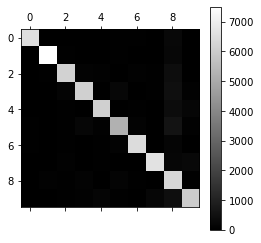

In [51]:
ova_confusion_matrix = confusion_matrix(mnist_target, ova_train_predict)
print(ova_confusion_matrix)
plt.matshow(ova_confusion_matrix, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

<class 'numpy.ndarray'>


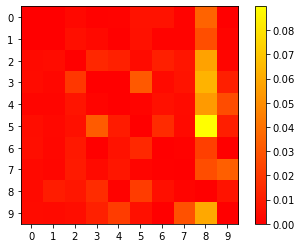

In [55]:
print(type(ova_confusion_matrix))
ova_row_sums = np.sum(ova_confusion_matrix, axis=1, keepdims=True)
ova_confusion_matrix_norm = ova_confusion_matrix / ova_row_sums
np.fill_diagonal(ova_confusion_matrix_norm,0)

plt.imshow(ova_confusion_matrix_norm, cmap=plt.cm.autumn)
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

#### 处理误差的方法
1. 收集更多的数据
2. 进行数据预处理
3. 构造有助于分类器的特征

## 多标签分类器

1. 假定有两个标签
    1. 标签一： 数字小于3
    2. 标签二： 数字是奇数
2. 这里使用knn分类器进行分类
3. 参数说明
    1. mnist_data_train 训练数据
    2. target_train_mullabel 训练标签

In [56]:
from sklearn.neighbors import KNeighborsClassifier

target_train_small = (mnist_target_train <= 3)
target_train_odd = (mnist_target_train % 2 ==1)

# 预测函数为一个（2，60001 ）的矩阵，因此单个数据的预测结果是一个（2，）列向量
# np.r_ == pd.concat
# np.c_ == pd.merge
target_train_mullabel = np.c_[target_train_small, target_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(mnist_data_train, target_train_mullabel)

KNeighborsClassifier()

In [57]:
knn_clf.predict([sp_sample])

array([[ True,  True]])

In [61]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

target_train_knn_pred = cross_val_predict(knn_clf, mnist_data_train, target_train_mullabel, cv=3)
f1_score_knn = f1_score(target_train_mullabel, target_train_knn_pred, average='weighted')

0.981992665300666
()


In [63]:
print(f1_score_knn)

0.981992665300666


## 多输出分类器

1. 首先对数据集进行skew操作，添加随机噪声
    1. 训练集噪声 noise_train
    2. 测试集噪声 noise_test
    3. 噪声训练集 mnist_data_train_mod | mnist_target_train_mod
    4. 噪声测试集 mnist_data_test_mod | mnist_target_test_mod
2. 多输出的每一个输出标签相当于是每一个像素点的预测值
3. 多输出分类器只是多标签分类器的一个泛化，一个标签可以有多个值

In [87]:
from numpy import random as rnd
noise_train = rnd.randint(0, 100, (len(mnist_data_train), 784))
noise_test = rnd.randint(0, 100, (len(mnist_data_test),784))

mnist_data_train_mod = mnist_data_train + noise_train
mnist_data_test_mod = mnist_data_test + noise_test
mnist_target_train_mod = mnist_data_train
mnist_target_test_mod = mnist_data_test

Text(0.5, 1.0, 'original digit image')

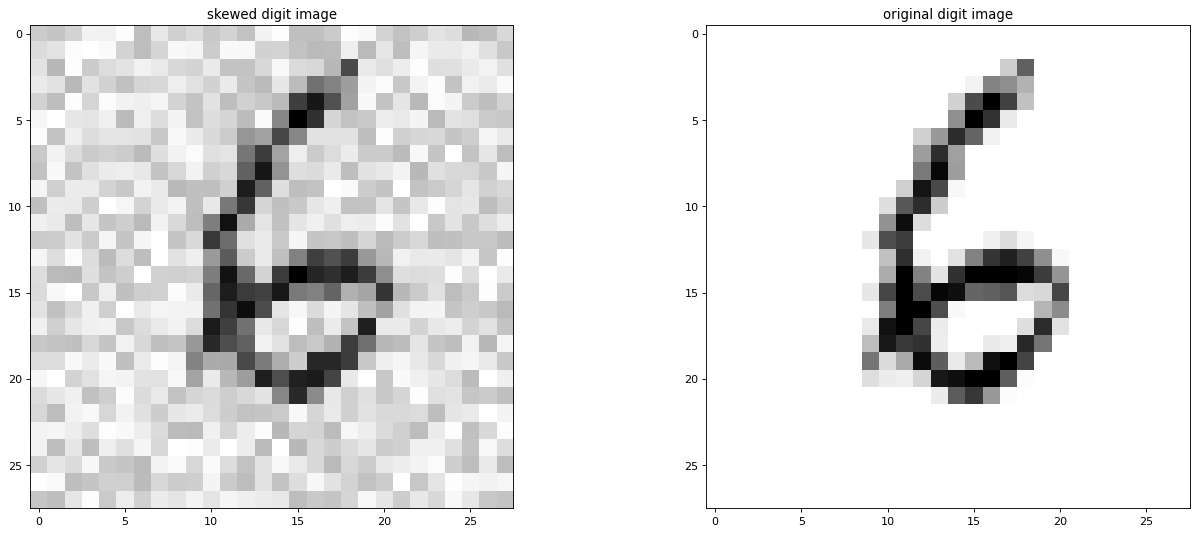

In [79]:
sp_sample_mod = mnist_data_test_mod[2000,:]
sp_sample_image_mod = sp_sample_mod.reshape([28,28])
plt.figure(figsize=(20,8),dpi=80)
plt.subplot(1,2,1).imshow(sp_sample_image_mod, cmap=plt.cm.binary, interpolation='nearest')
plt.subplot(1,2,1).set_title("skewed digit image")
plt.subplot(1,2,2).imshow(mnist_data_test[2000,:].reshape([28,28]),
                         cmap=plt.cm.binary, interpolation='nearest')
plt.subplot(1,2,2).set_title("original digit image")

Text(0.5, 1.0, 'cleaned digit image')

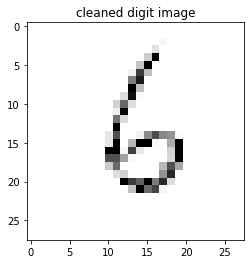

In [89]:
from sklearn.neighbors import KNeighborsClassifier

knn_mul_clf = KNeighborsClassifier()
knn_mul_clf.fit(mnist_data_train_mod, mnist_target_train_mod)
clean_digit = knn_mul_clf.predict([mnist_data_test[2000,:]])

plt.imshow(clean_digit.reshape([28,28]), cmap=plt.cm.binary,interpolation='nearest')
plt.title("cleaned digit image")